# Example 4
Intente resolver dos casos diferentes del problema TSP usando Simulated Annealing y un Algoritmo Evolutivo. El primer problema es de 29 ciudades y el segundo, de 101 ciudades.
Las ubicaciones de las ciudades se encuentran dentro de una matriz contenida en el archivo con extensión 'cities.npy' mientras que los costos de ir de una ciudad a otra están contenidos en otra matriz almacenada en el archivo con extensión 'distances.npy'. Para ambos casos, se conocen las soluciones óptimas, las cuales se encuentran en los archivos con extensión 'opt.tour.npy'.
 
Se pide que:

a) Proponga una representación adecuada para las soluciones.

b) Proponga una función de evaluación que le permita calcuar que tan buena es una solución.

c) Defina como se generarán las soluciones vecinas al usar Simulated Annealing y cuales serán los operadores empleados en el Algoritmo Evolutivo.

d) Implemente y pruebe lo de nido en los puntos anteriores. Evalúe los resultados obtenidos. Detalle todos los parámetros usados durante la ejecución de ambos algoritmos. Justifique.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


#from matplotlib import pylab
#import mpld3

%matplotlib  inline
#mpld3.enable_notebook()

from utils.busqueda_local import hill_climb
from utils.busqueda_local import simulated_annealing
from deap import base, creator, tools, algorithms

In [2]:
# -*- coding: utf-8 -*-
"""
Example 4: Problema del Viajante.
"""

CIUDADES = np.load('resources/bayg29.cities.npy')
DISTANCIAS = np.load('resources/bayg29.distances.npy') # [29,29]
RECORRIDO_OPTIMO = np.load('resources/bayg29.opt.tour.npy')  # Distancia mínima: 1610

#CIUDADES = np.load('resources/eil101.cities.npy')
#DISTANCIAS = np.load('resources/eil101.distances.npy')
#RECORRIDO_OPTIMO = np.load('resources/eil101.opt.tour.npy')  # Distancia mínima: 629

def distancia_recorrido(recorrido):
    """ Devuelve el largo total del recorrido. """
    largo = 0
    ciudad_anterior = recorrido[-1]
    for ciudad in recorrido:
        largo += DISTANCIAS[ciudad_anterior, ciudad]
        ciudad_anterior = ciudad
    return largo


def mostrar_recorrido(recorrido):
    r = recorrido + [recorrido[0]]
    plt.figure(1)
    plt.clf()
    plt.plot(CIUDADES[0], CIUDADES[1], 'o')
    plt.plot(CIUDADES[0, r], CIUDADES[1, r], 'r')
    plt.show()



# Simulated Annealing
## Nuevos

In [3]:
def nuevos():
    a=np.arange(CIUDADES.shape[1])
    np.random.shuffle(a)
    return a

## Evaluacion

In [4]:
def evaluacion(x):
    return -distancia_recorrido(x)

## Vecinos

In [5]:
def invertirPos(x,pos1,pos2):
    aaa=x[pos1]
    x[pos1]=x[pos2]
    x[pos2]=aaa
    return x

def vecinos(x):
    v = []
    pos=np.random.randint(0,x.size,3)
    while pos[0]==pos[1] & pos[1]==pos[2]:
        pos=np.random.randint(0,x.size,3)
    v.append(invertirPos(x,pos[0],pos[1]))
#    v.append(invertirPos(x,pos[0],pos[2]))
#    v.append(invertirPos(x,pos[1],pos[2]))
    return v

## Defino Temperaturas

In [6]:
# Probabilidad prob de elejir soluciones peores con diferencia mayor a dif al inicio
dif  = 0.5
prob = 0.03
T_max = -dif / np.log(prob)
# Probabilidad prob de elejir soluciones peores con diferencia mayor a dif al final
dif  = 0.05
prob = 0.03
T_min = -dif / np.log(prob)
# Factor de reduccion de acuerdo a las iteraciones deseadas
N = 30
reduccion = np.exp(np.log(T_min / T_max) / N)

## Busco

In [7]:
def buscar(i):
    mejor = nuevos()
    e=0
    for j in range(i):
        mejor, evaluaciones = simulated_annealing(mejor, evaluacion, vecinos,
                                          T_max=T_max, 
                                          T_min=T_min, 
                                          reduccion=reduccion)
        e+=evaluaciones
    print "Cantidad de soluciones evaluadas:", evaluaciones
    print "Valor de func para esa solución:", evaluacion(RECORRIDO_OPTIMO)-evaluacion(mejor)
    return mejor

In [8]:
mejorEncontrado = buscar(50)

Cantidad de soluciones evaluadas: 31
Valor de func para esa solución: 2841


# Algoritmo Evolutivo

## Defino Fitness Esperado

In [9]:
creator.create("Fitness", base.Fitness, weights=(evaluacion(RECORRIDO_OPTIMO),))
creator.create("Individual", list, fitness=creator.Fitness)

## Defino ADN del Individuo

In [10]:
def nuevoCamino():
    a=np.arange(CIUDADES.shape[1])
    np.random.shuffle(a)
    return a

In [11]:
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, nuevoCamino)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## Defino Evaluacion, Seleccion y Mutacion

In [12]:
def evaluarADN(x):
    return [distancia_recorrido(x)]

In [13]:
toolbox.register("evaluate", evaluarADN)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.40)
toolbox.register("select", tools.selTournament, tournsize=5)

In [14]:
def main():    
    pop = toolbox.population(n=1000)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, stats=stats, halloffame=hof, verbose=True)
    return pop, logbook, hof

gen	nevals	avg    	min 	max 
0  	1000  	4751.01	3304	5693
1  	628   	4464.74	3304	5543
2  	602   	4238.67	3304	5465
3  	625   	4057.84	3100	5587
4  	582   	3859.18	3100	5456
5  	603   	3717.02	2887	5419
6  	585   	3586.14	2887	5413
7  	606   	3516.3 	2793	5477
8  	646   	3480.64	2805	5730
9  	589   	3389.64	2698	5455
10 	620   	3390.89	2661	5298
11 	628   	3328.8 	2626	5334
12 	590   	3216.39	2584	5529
13 	600   	3195.63	2426	5660
14 	596   	3133.37	2426	5621
15 	586   	3057.3 	2426	5622
16 	598   	3005.78	2289	5367
17 	621   	2981.91	2289	5695
18 	611   	2905.79	2255	5497
19 	585   	2899.32	2220	5740
20 	628   	2828.4 	2166	5435
21 	553   	2702.85	2084	5327
22 	606   	2782.76	2084	5511
23 	631   	2724.82	2012	5261
24 	630   	2679.84	1976	5331
25 	642   	2678.94	1976	5606
26 	605   	2561.23	1974	5381
27 	605   	2565.42	1881	5721
28 	576   	2489.18	1881	5488
29 	618   	2485.91	1865	5168
30 	557   	2435.31	1865	5647
31 	584   	2423.2 	1827	5482
32 	613   	2435.66	1817	5300
33 	573   	234

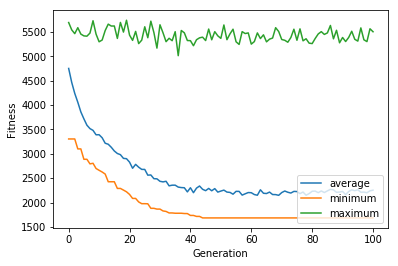

In [18]:
if __name__ == "__main__":
    pop, log, hof = main()
    print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
    gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
    plt.plot(gen, avg, label="average")
    plt.plot(gen, min_, label="minimum")
    plt.plot(gen, max_, label="maximum")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend(loc="lower right")

Mejor Encontrado: 1684


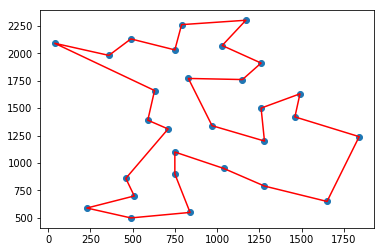

In [19]:
print "Mejor Encontrado:", -evaluacion(hof[0])
mostrar_recorrido(hof[0])

MEJOR RECORRIDO: 1610


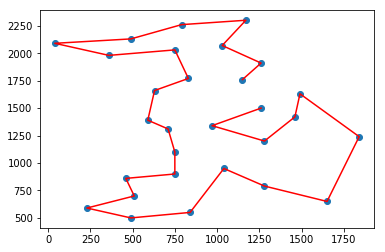

In [20]:
print "MEJOR RECORRIDO:", -evaluacion(RECORRIDO_OPTIMO)
mostrar_recorrido(RECORRIDO_OPTIMO)